# Generating Weekday and Weekend profiles

In [9]:
import polars as pl
import glob
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import logging
from tslearn.clustering import TimeSeriesKMeans 
import re

logging.getLogger('matplotlib.font_manager').disabled = True

from validation import validation

## Preparing Profiles for each day of the week

In [22]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_cleaned")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

def day_avg_preprocess_weekend(df, day_of_week):
    # Parse the timestamp column (assuming 'zeitpunkt' column exists)
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )

    df = df.filter(pl.col("zeitpunkt_dt").dt.weekday().is_in([day_of_week]))
    
    # Extract time_of_day (hour, minute) as time component
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.time().alias("time_of_day")
    )
    
    # Group by time_of_day across all weekend days and average the energy column
    day_avg = (
        df.group_by("time_of_day")
          .agg(pl.col("bruttolastgang_kwh").mean().alias("day_avg_bruttolastgang_kwh"))
          .sort("time_of_day")
    )
    return day_avg

def normalize(df):
    """ Normalize the 'day_avg_bruttolastgang_kwh' column by its max value and overwrite the original column """
    max_val = df.select(pl.max("day_avg_bruttolastgang_kwh"))['day_avg_bruttolastgang_kwh'][0]
    
    if max_val == 0:
        # Avoid division by zero, leave values unchanged
        df = df.with_columns(
            pl.col("day_avg_bruttolastgang_kwh")
        )
    else:
        # Overwrite original column with normalized values
        df = df.with_columns(
            (pl.col("day_avg_bruttolastgang_kwh") / max_val).alias("day_avg_bruttolastgang_kwh")
        )

    return df

base_output_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_weekly_normalized")



for day in [1, 2, 3, 4, 5, 6, 7]:

    day_folder = base_output_folder / f"SM_DATA_weekly_normalized_{day}"
    day_folder.mkdir(parents=True, exist_ok=True)

    for file_path in file_paths:
        df = pl.read_csv(file_path)
        day_avg = day_avg_preprocess_weekend(df, day)
        day_avg = normalize(day_avg)

        filename = os.path.basename(file_path)  # Original file name
        output_file = day_folder / filename  # Output path with same filename

        day_avg.write_csv(output_file)

## Clustering of specified day

In [12]:
day_of_week = 2 # 1=Monday, 2=Tuesday, ..., 7=Sunday

input_folder = Path(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_weekly_normalized/SM_DATA_weekly_normalized_{day_of_week}')

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data = data_3d

Shape of the 3D array: (1464, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


In [13]:
#validation(data_3d)

In [14]:
n_clusters = 4  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)



3.928 --> 2.673 --> 2.557 --> 2.492 --> 2.471 --> 2.464 --> 2.461 --> 2.459 --> 2.458 --> 2.458 --> 2.458 --> 2.458 --> 2.458 --> 2.458 --> 


In [15]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
house_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1
}).sort("cluster")
result_df.write_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/weekly_avg_clustering_{day_of_week}.csv')

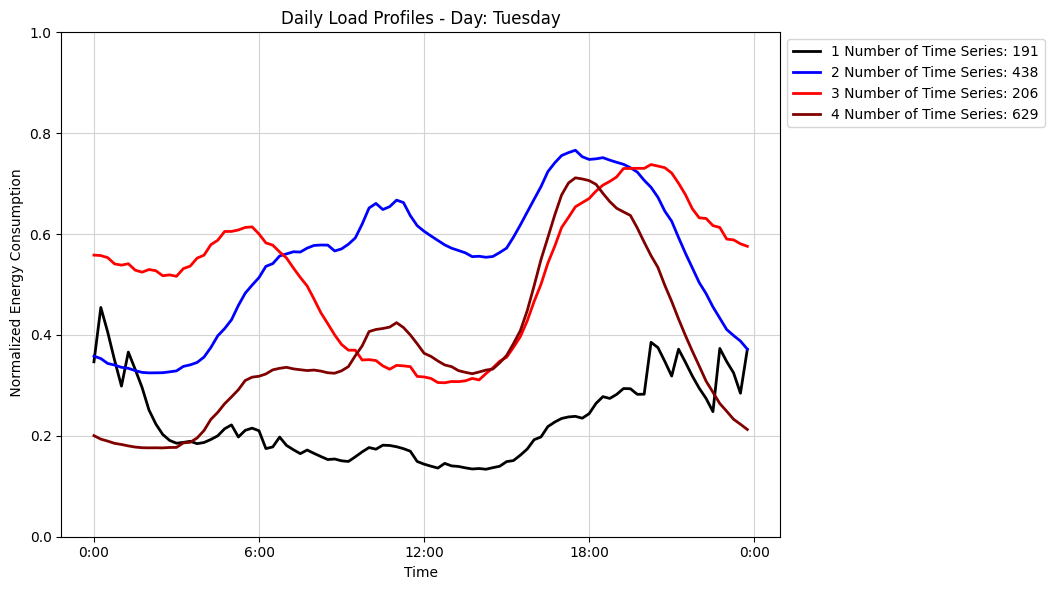

In [16]:
labels = ['0:00','6:00','12:00','18:00','0:00']
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

colors= ['black','blue','red','maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','magenta','pink','violet']

def plot_clusters_season():
    
    plt.figure(figsize=(8,6))
    for cluster_idx in range(n_clusters):
        # Get all time series in this cluster
        cluster_data = train_data[clusters_train == cluster_idx]
        cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
        # Calculate the mean time series for the cluster
        mean_time_series = np.mean(cluster_data, axis=0)
    
        # Plot the mean time series
        cluster_no = cluster_idx+1
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'{cluster_no} Number of Time Series: {len(cluster_indices)}',
                linewidth =2, color=colors[cluster_idx] )
        
    day_str = day_names[day_of_week -1]    
    plt.title(f'Daily Load Profiles - Day: {day_str}')
    plt.xlabel("Time")
    plt.ylabel(" Normalized Energy Consumption")
    plt.ylim(0,1)
    #plt.xticks(range(1,108,12),labels=labels)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    plt.legend()
    #plt.margins(0)
    plt.grid(True, color = 'lightgray')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots_daily/" \
    "daily_evolution_"+ day_str +".png")
    plt.show()
    

plot_clusters_season()

In [28]:
# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "avg_day_1",
        "avg_day_2",
        "avg_day_3",
        "avg_day_4",
        "avg_day_5",
        "avg_day_6",
        "avg_day_7"
    ]),
    on="ch_id_clean",
    how="left"
)
# Now select in the desired order
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "avg_day_1",
    "avg_day_2",
    "avg_day_3",
    "avg_day_4",
    "avg_day_5",
    "avg_day_6",
    "avg_day_7"
])

#print(result_df.head())

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_yearly_consumption [kWh]"),
    pl.mean("avg_day_1").alias("Mo[kWh]").round(1),
    pl.mean("avg_day_2").alias("Di[kWh]").round(1),
    pl.mean("avg_day_3").alias("Mi[kWh]").round(1),
    pl.mean("avg_day_4").alias("Do[kWh]").round(1),
    pl.mean("avg_day_5").alias("Fr[kWh]").round(1),
    pl.mean("avg_day_6").alias("Sa[kWh]").round(1),
    pl.mean("avg_day_7").alias("So[kWh]").round(1),
]).sort("cluster")

# Compute overall averages
overall_yearly_avg = result_df["bruttolastgang_kwh_sum"].mean()
overall_day_avg_1 = result_df['avg_day_1'].mean()
overall_day_avg_2 = result_df['avg_day_2'].mean()
overall_day_avg_3 = result_df['avg_day_3'].mean()
overall_day_avg_4 = result_df['avg_day_4'].mean()
overall_day_avg_5 = result_df['avg_day_5'].mean()
overall_day_avg_6 = result_df['avg_day_6'].mean()
overall_day_avg_7 = result_df['avg_day_7'].mean()

cluster_summary = cluster_summary.with_columns([
    pl.col("cluster").cast(pl.Utf8)
])
summary_row = pl.DataFrame({
    "cluster": ["Average"],  # Use 0 or a valid UInt32 value for summary row
    "num_households": [result_df["house_id"].n_unique()],
    "avg_yearly_consumption [kWh]": [overall_yearly_avg],
    "Mo[kWh]": [overall_day_avg_1],
    "Di[kWh]": [overall_day_avg_2],
    "Mi[kWh]": [overall_day_avg_3],
    "Do[kWh]": [overall_day_avg_4],
    "Fr[kWh]": [overall_day_avg_5],
    "Sa[kWh]": [overall_day_avg_6],
    "So[kWh]": [overall_day_avg_7],
})

# Cast to match schema, e.g. cluster and num_households to UInt32
summary_row = summary_row.with_columns([
    pl.col("cluster").cast(cluster_summary["cluster"].dtype),
    pl.col("num_households").cast(cluster_summary["num_households"].dtype)
])

# Concatenate now that dtypes match
final_summary = pl.concat([cluster_summary, summary_row])

print(final_summary)



shape: (5, 10)
┌─────────┬───────────────┬──────────────┬──────────┬───┬──────────┬──────────┬─────────┬──────────┐
│ cluster ┆ num_household ┆ avg_yearly_c ┆ Mo[kWh]  ┆ … ┆ Do[kWh]  ┆ Fr[kWh]  ┆ Sa[kWh] ┆ So[kWh]  │
│ ---     ┆ s             ┆ onsumption   ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---     ┆ ---      │
│ str     ┆ ---           ┆ [kWh]        ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64     ┆ f64      │
│         ┆ u32           ┆ ---          ┆          ┆   ┆          ┆          ┆         ┆          │
│         ┆               ┆ f64          ┆          ┆   ┆          ┆          ┆         ┆          │
╞═════════╪═══════════════╪══════════════╪══════════╪═══╪══════════╪══════════╪═════════╪══════════╡
│ 1       ┆ 191           ┆ 5639.57823   ┆ 9.9      ┆ … ┆ 9.5      ┆ 9.7      ┆ 10.2    ┆ 10.4     │
│ 2       ┆ 438           ┆ 4831.318148  ┆ 8.5      ┆ … ┆ 8.1      ┆ 8.4      ┆ 8.6     ┆ 8.9      │
│ 3       ┆ 206           ┆ 7360.226354  ┆ 11.4     ┆ … ┆ 11.2     ┆ 11.6   

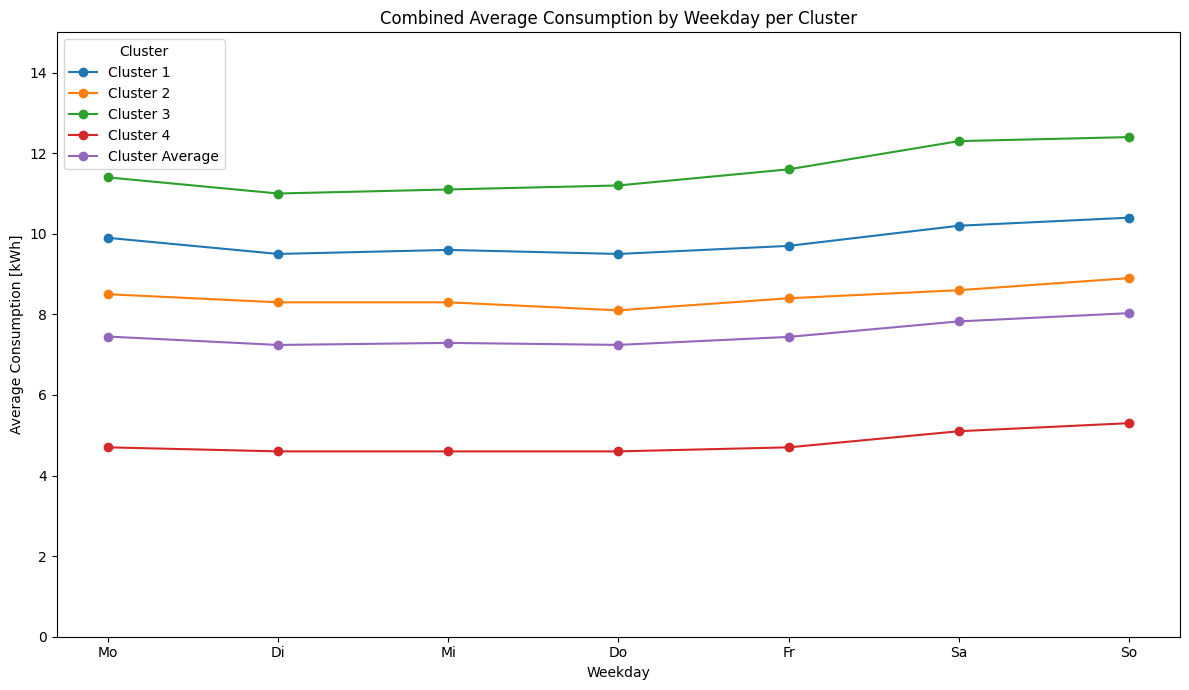

In [31]:
days = ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So']
clusters = final_summary["cluster"].to_list()

plt.figure(figsize=(12, 7))

for cluster in clusters:
    # Filter the cluster row
    row = final_summary.filter(pl.col("cluster") == cluster).select([
        "Mo[kWh]", "Di[kWh]", "Mi[kWh]", "Do[kWh]", "Fr[kWh]", "Sa[kWh]", "So[kWh]"
    ])
    consumption = row[0, :].to_numpy().flatten().tolist()
    plt.plot(days, consumption, marker='o', label=f"Cluster {cluster}")

plt.xlabel('Weekday')
plt.ylabel('Average Consumption [kWh]')
plt.title('Combined Average Consumption by Weekday per Cluster')
plt.legend(title='Cluster')
plt.ylim(0,15)
plt.grid(False)
plt.tight_layout()
plt.show()